In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from base_data_handler import BaseDataHandler
from sklearn.datasets import fetch_california_housing

In [14]:
# Load dataset
housing = fetch_california_housing()

# Convert to DataFrame
df = pd.DataFrame(housing.data, columns=housing.feature_names)

# Add target column (median house value)
df['MedHouseVal'] = housing.target
# Quick check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [15]:
handler = BaseDataHandler(df=df)

In [16]:
_ = handler.try_clean_column_names()
handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   med_inc        20640 non-null  float64
 1   house_age      20640 non-null  float64
 2   ave_rooms      20640 non-null  float64
 3   ave_bedrms     20640 non-null  float64
 4   population     20640 non-null  float64
 5   ave_occup      20640 non-null  float64
 6   latitude       20640 non-null  float64
 7   longitude      20640 non-null  float64
 8   med_house_val  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


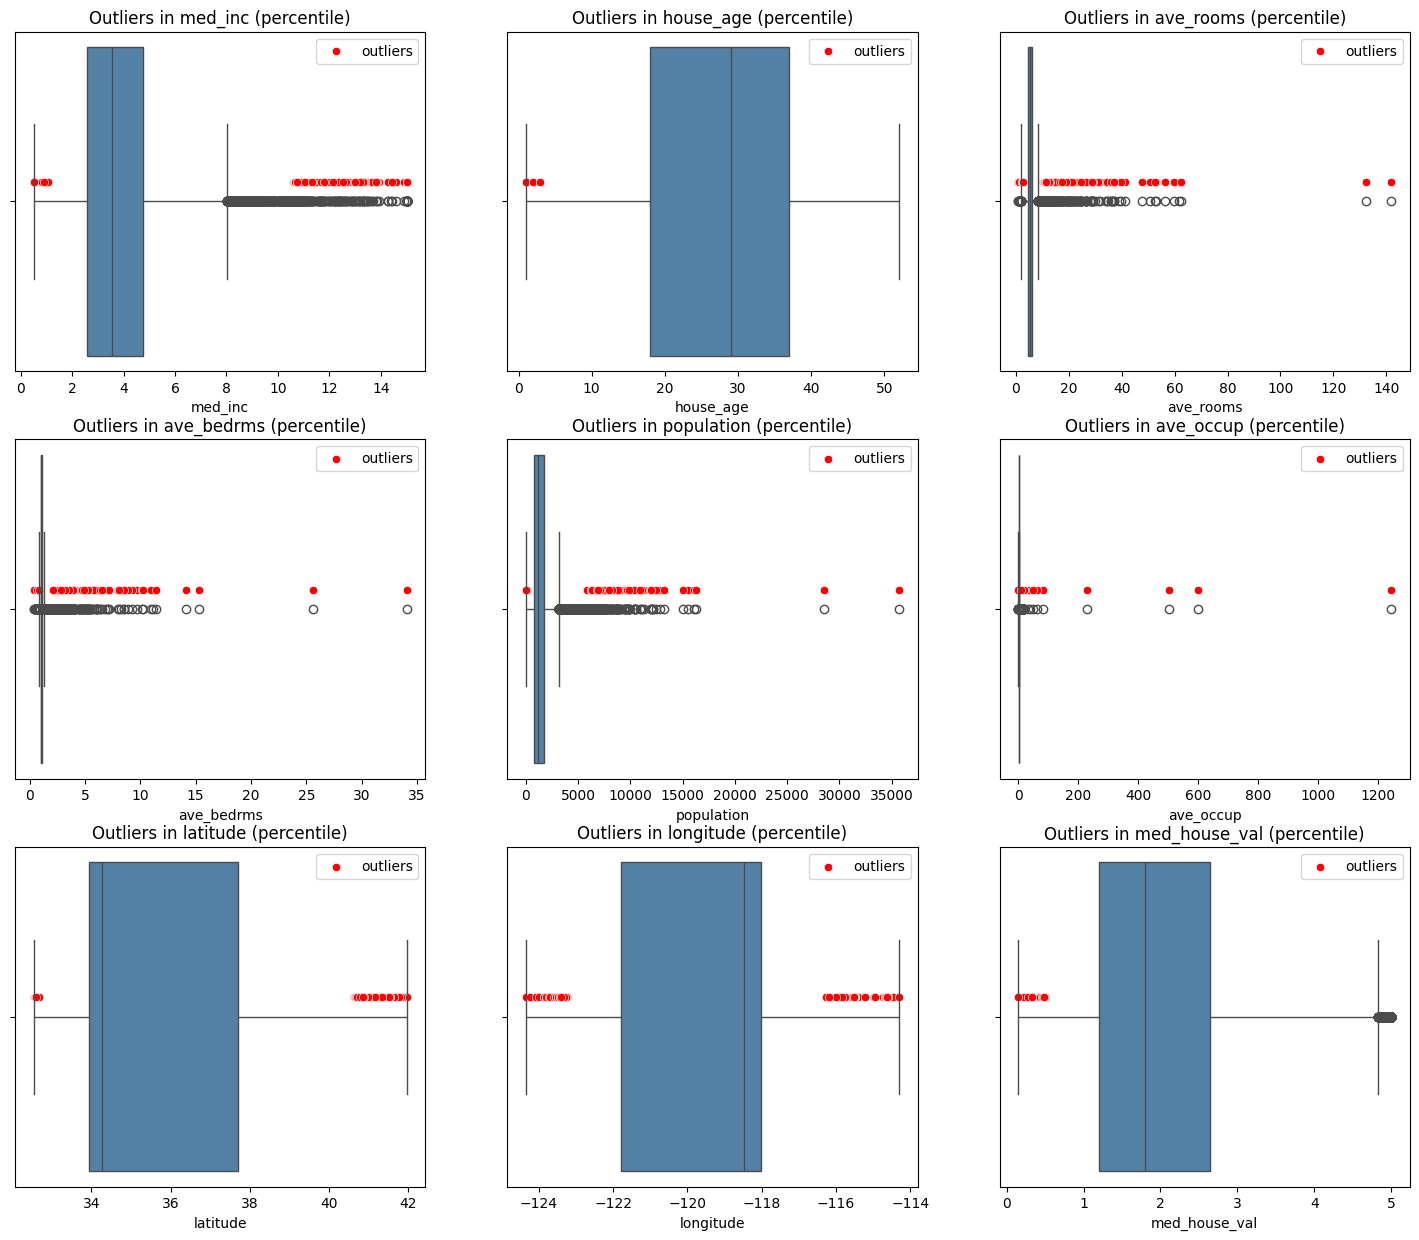

In [17]:
fig, ax = handler.get_outlier_case_study()

In [18]:
mask = handler.get_outliers_df()
handler.df = handler.df[~mask]
handler.df.dropna(inplace=True)
handler.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16312 entries, 2 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   med_inc        16312 non-null  float64
 1   house_age      16312 non-null  float64
 2   ave_rooms      16312 non-null  float64
 3   ave_bedrms     16312 non-null  float64
 4   population     16312 non-null  float64
 5   ave_occup      16312 non-null  float64
 6   latitude       16312 non-null  float64
 7   longitude      16312 non-null  float64
 8   med_house_val  16312 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


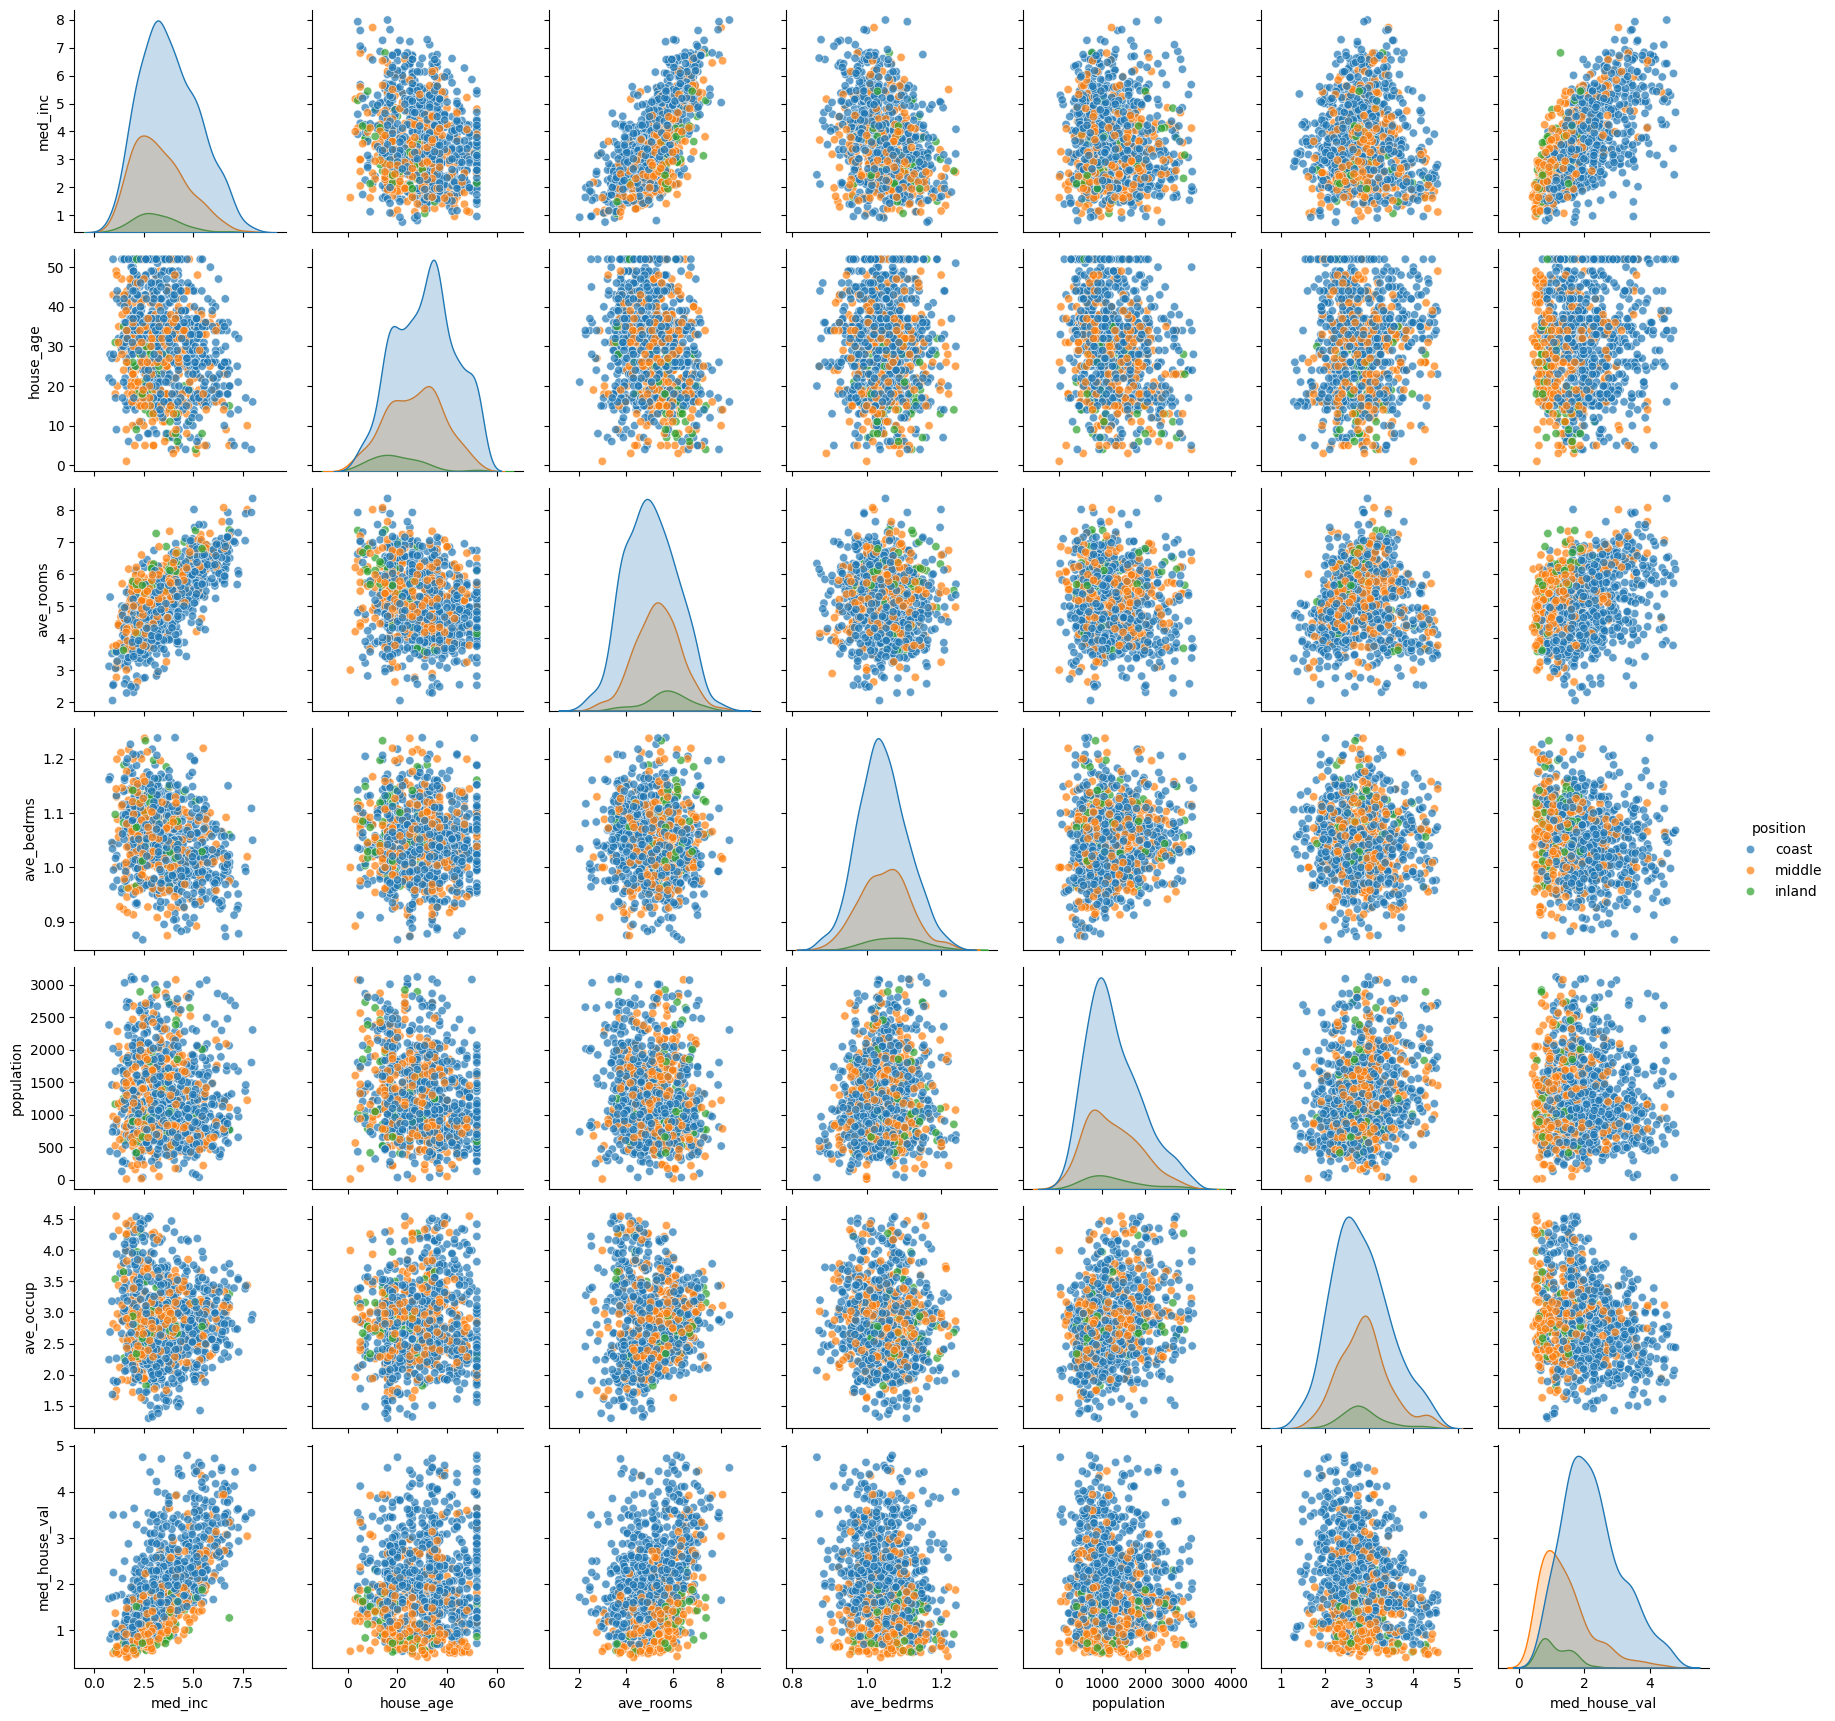

In [19]:
# Haversine distance (km)
# Fit a simple coastline curve: lon ≈ f(lat)
# Rough anchor pairs (lat, lon) along CA coast (north→south)
# Crescent City, Point Arena, SF outer coast, Monterey, Santa Barbara, LA, San Diego
_LAT = np.array([41.8, 39.0, 37.7, 36.6, 34.4, 34.0, 32.7])
_LON = np.array([-124.2, -123.7, -122.5, -121.9, -120.3, -118.5, -117.2])

# Quadratic fit: lon = a*lat^2 + b*lat + c
_COAST_COEFFS = np.polyfit(_LAT, _LON, deg=2)
def _coast_lon(lat):
    a, b, c = _COAST_COEFFS
    return a*lat*lat + b*lat + c

def classify_location(lat, lon):
    # Compute expected coastline longitude at this latitude
    coast_at_lat = _coast_lon(lat)

    # Buffer so "coast" means within ~25–35 km west of the curve
    # ~0.25 deg lon ≈ ~22–28 km at CA latitudes
    coast_buffer = 1

    # Inland threshold: east of valley ridge (rough guide)
    # Piecewise inland curve (looser than coast), using a shift from the coastline
    inland_shift = 2.3  # degrees of longitude east from the coast curve
    inland_at_lat = coast_at_lat + inland_shift

    if lon <= coast_at_lat + coast_buffer:
        return "coast"
    elif lon >= inland_at_lat:
        return "inland"
    else:
        return "middle"


_ = handler.try_add_col(target_col="position", func=lambda row: classify_location(row['latitude'],row['longitude']))

sns.pairplot(
    handler.sample_df(),
    vars=["med_inc", "house_age", "ave_rooms", "ave_bedrms", "population", "ave_occup", "med_house_val"],
    hue="position",
    diag_kind="kde",
    plot_kws={"alpha":0.7}
)


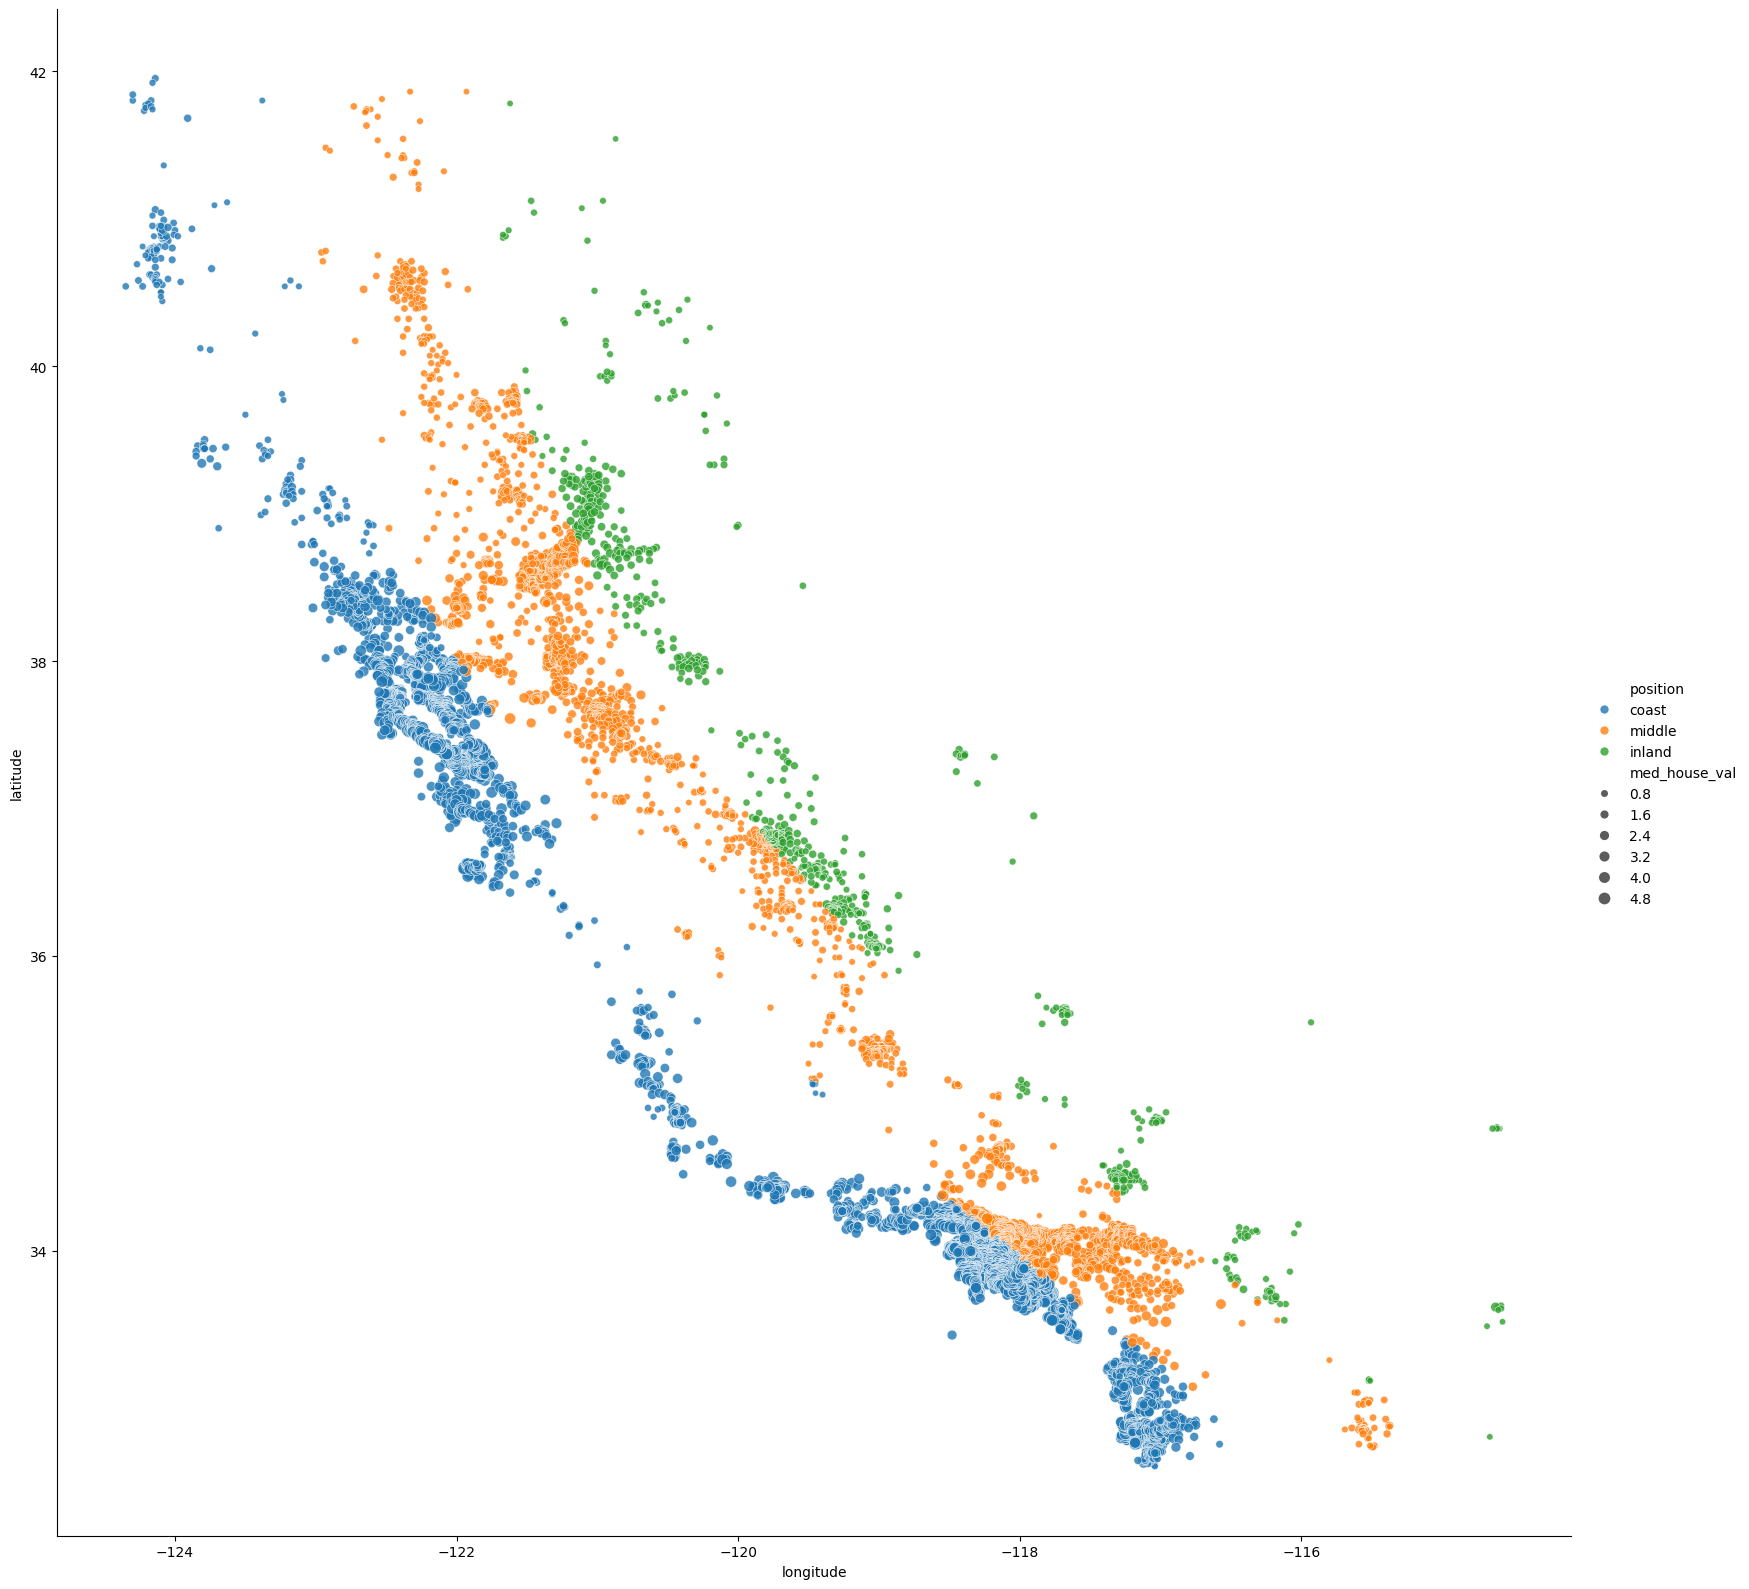

In [20]:
sns.relplot(
    data=handler.df,
    x="longitude",
    y="latitude",
    hue="position",
    size="med_house_val",
    alpha=.8,
    height=16
)

In [21]:
def add_population_per_cell(df, lat_col="latitude", lon_col="longitude", pop_col="population",
                            lat_bin=0.1, lon_bin=0.1):
    df = df.copy()
    # Create bins
    df["_lat_bin"] = (df[lat_col] // lat_bin) * lat_bin
    df["_lon_bin"] = (df[lon_col] // lon_bin) * lon_bin
    
    # Aggregate population per bin
    pop_map = (
        df.groupby(["_lat_bin", "_lon_bin"])[pop_col]
        .sum()
        .reset_index()
        .rename(columns={pop_col: "pop_per_cell"})
    )
    
    # Merge back
    df = df.merge(pop_map, on=["_lat_bin", "_lon_bin"], how="left")
    return df.drop(columns=["_lat_bin", "_lon_bin"])

handler.df = add_population_per_cell(handler.df)

<Axes: xlabel='med_house_val', ylabel='pop_per_cell'>

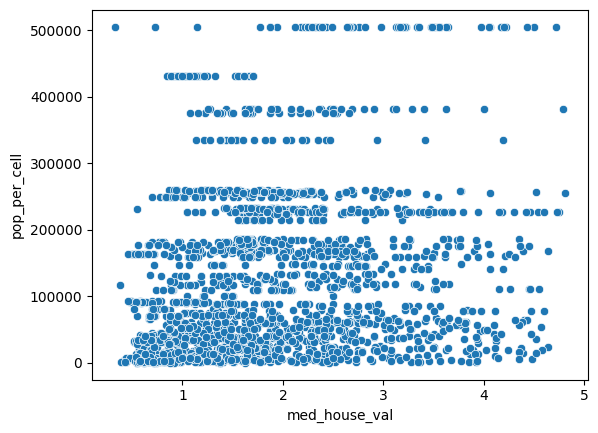

In [22]:
sns.scatterplot(
    data=handler.df.sample(2000, random_state=42),
    x="med_house_val", y="pop_per_cell"
)